In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import *
from keras.layers import *

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

In [ ]:
NB_ACCUMULATIONS = 16

class MyModel(Sequential):

	def __init__(self, **kwargs):

		super().__init__(**kwargs)


	def compile(self, **kwargs):

		super().compile(**kwargs)

		self.acculumated_gradients = [
			tf.Variable(
				initial_value = tf.zeros_like(v, dtype = tf.float32),
				trainable = False,
				dtype = tf.float32
			)
			for v in self.trainable_variables
		]

		self.acculation_counter = tf.Variable(
			initial_value = 0,
			trainable = False,
			dtype = tf.int32
		)

	@tf.function
	def train_step(self, data):

		x, y = data

		with tf.GradientTape() as tape:
			pred = self(x, training = True)
			loss = self.compiled_loss(y, pred, regularization_losses = self.losses)

		grads = tape.gradient(loss, self.trainable_variables)

		for i in range(len(grads)):
			self.acculumated_gradients[i].assign_add(grads[i] / float(NB_ACCUMULATIONS))

		self.acculation_counter.assign_add(1)

		if self.acculation_counter >= NB_ACCUMULATIONS:

			self.optimizer.apply_gradients(zip(self.acculumated_gradients, self.trainable_variables))

			for i in range(len(grads)):
				self.acculumated_gradients[i].assign(tf.zeros_like(grads[i], dtype = tf.float32))

			self.acculation_counter.assign(0)

		self.compiled_metrics.update_state(y, pred)

		return {m.name: m.result() for m in self.metrics}

In [ ]:
model = MyModel()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs = 3, batch_size = 4, validation_data = (x_test, y_test))

In [ ]:
print(list(history.history['loss']))
print(list(history.history['val_loss']))

In [ ]:
import numpy as np

a = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# apply softmax
b = np.exp(a) / np.sum(np.exp(a))

probabilities = b
probabilities = np.log(probabilities) / 0.5
probabilities = np.exp(probabilities) / np.sum(np.exp(probabilities))

sorted_indices = np.argsort(-probabilities)
print(sorted_indices)
cumsum_probabilites = np.cumsum(probabilities[sorted_indices])
print(cumsum_probabilites)
cutoff_index = np.searchsorted(cumsum_probabilites, cumsum_probabilites[0] + 1e-6)
print(cutoff_index)
new_probabilities = np.zeros_like(probabilities)
print(new_probabilities)
new_probabilities[sorted_indices[:cutoff_index]] = probabilities[sorted_indices[:cutoff_index]]
print(new_probabilities)
new_probabilities /= np.sum(new_probabilities)
print(new_probabilities)

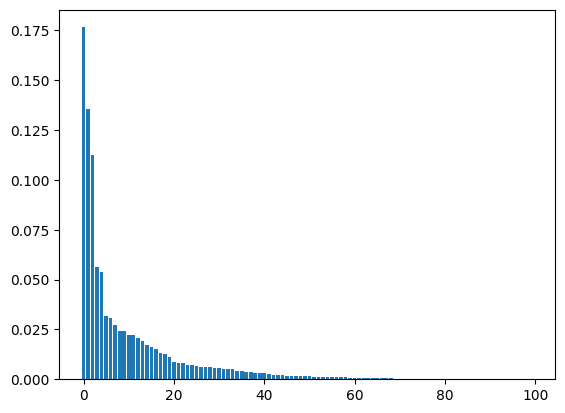

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [109]:
import numpy as np
import matplotlib.pyplot as plt

a = np.random.normal(0, 1, 100)
a = sorted(a, reverse = True)

a = np.exp(a) / np.sum(np.exp(a))
a = np.log(a)
a /= 0.5
a[0] *= 1.1
a = np.exp(a) / np.sum(np.exp(a))

plt.bar(range(len(a)), a)
plt.show()

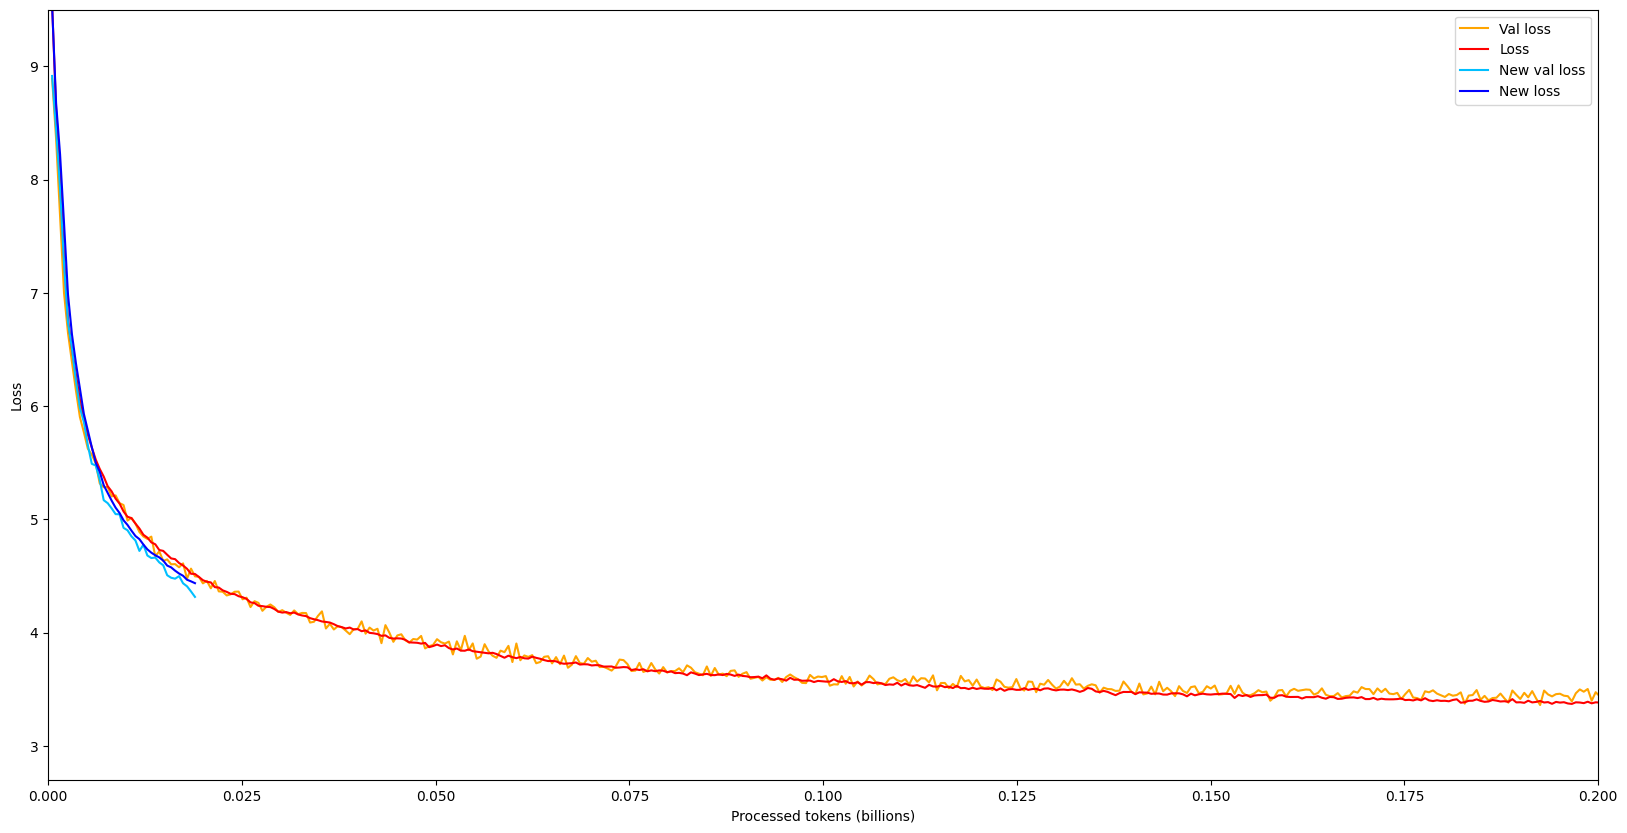

Loss: 2.96185302734375 (-0.21749840428432018)
Val loss: 3.0604889392852783 (-0.13156129668156125)
New loss: 4.435783863067627 (0)
New val loss: 4.3145670890808105 (0)


In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

logs = pickle.load(open('./bacup/gpt_64/logs.pkl', 'rb'))
new_logs = pickle.load(open('./output/logs.pkl', 'rb'))

x_loss = np.array(logs['tokens']) / 1e9
y_loss = logs['loss']

x_val_loss = np.array(logs['tokens']) / 1e9
y_val_loss = logs['val_loss']

x_new_loss = np.array(new_logs['tokens']) / 1e9
y_new_loss = new_logs['loss']

x_new_val_loss = np.array(new_logs['tokens']) / 1e9
y_new_val_loss = new_logs['val_loss']

loss_slope = (np.mean(y_loss[-100:]) - np.mean(y_loss[-400:-300])) / (np.mean(x_loss[-100:]) - np.mean(x_loss[-400:-300]))
val_loss_slope = (np.mean(y_val_loss[-100:]) - np.mean(y_val_loss[-400:-300])) / (np.mean(x_val_loss[-100:]) - np.mean(x_val_loss[-400:-300]))

if len(y_new_loss) > 400:
	new_loss_slope = (np.mean(y_new_loss[-100:]) - np.mean(y_new_loss[-400:-300])) / (np.mean(x_new_loss[-100:]) - np.mean(x_new_loss[-400:-300]))
	new_val_loss_slope = (np.mean(y_new_val_loss[-100:]) - np.mean(y_new_val_loss[-400:-300])) / (np.mean(x_new_val_loss[-100:]) - np.mean(x_new_val_loss[-400:-300]))
else:
	new_loss_slope = 0
	new_val_loss_slope = 0

duration = 10

x_loss_pred = np.array([np.mean(x_loss[-10:]), np.mean(x_loss[-10:]) + duration])
y_loss_pred = np.array([np.mean(y_loss[-10:]), np.mean(y_loss[-10:]) + duration * loss_slope])

x_val_loss_pred = np.array([np.mean(x_val_loss[-10:]), np.mean(x_val_loss[-10:]) + duration])
y_val_loss_pred = np.array([np.mean(y_val_loss[-10:]), np.mean(y_val_loss[-10:]) + duration * val_loss_slope])

if len(y_new_loss) > 400:
	x_new_loss_pred = np.array([np.mean(x_new_loss[-10:]), np.mean(x_new_loss[-10:]) + duration])
	y_new_loss_pred = np.array([np.mean(y_new_loss[-10:]), np.mean(y_new_loss[-10:]) + duration * new_loss_slope])

	x_new_val_loss_pred = np.array([np.mean(x_new_val_loss[-10:]), np.mean(x_new_val_loss[-10:]) + duration])
	y_new_val_loss_pred = np.array([np.mean(y_new_val_loss[-10:]), np.mean(y_new_val_loss[-10:]) + duration * new_val_loss_slope])

plt.figure(figsize = (20, 10))

plt.plot(x_val_loss_pred, y_val_loss_pred, color = 'orange', alpha = 0.2)
plt.plot(x_loss_pred, y_loss_pred, color = 'red', alpha = 0.2)

if len(y_new_loss) > 400:
	plt.plot(x_new_val_loss_pred, y_new_val_loss_pred, color = 'deepskyblue', alpha = 0.2)
	plt.plot(x_new_loss_pred, y_new_loss_pred, color = 'blue', alpha = 0.2)

plt.plot(x_val_loss, y_val_loss, label = 'Val loss', color = 'orange')
plt.plot(x_loss, y_loss, label = 'Loss', color = 'red')

plt.plot(x_new_val_loss, y_new_val_loss, label = 'New val loss', color = 'deepskyblue')
plt.plot(x_new_loss, y_new_loss, label = 'New loss', color = 'blue')

plt.ylim(2.7, 9.5)
plt.xlim(0, 0.2)
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Processed tokens (billions)')
plt.show()

print('Loss:', np.min(logs['loss']), '(' + str(loss_slope) + ')')
print('Val loss:', np.min(logs['val_loss']), '(' + str(val_loss_slope) + ')')
print('New loss:', np.min(new_logs['loss']), '(' + str(new_loss_slope) + ')')
print('New val loss:', np.min(new_logs['val_loss']), '(' + str(new_val_loss_slope) + ')')

In [ ]:
import numpy as np
print(np.__version__)